**Author: Michell Germano** 

Check my linkedin: [https://www.linkedin.com/in/michell-fontenelle-germano-1a654159/](http://)


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt


# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('../input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

Here I will basically import the datasets and give a quick check on it 

In [ ]:
# Read input files


dataset = pd.read_csv("../input/walmart-recruiting-store-sales-forecasting/train.csv.zip", names=['Store','Dept','Date','weeklySales','isHoliday'],sep=',', header=0)
features = pd.read_csv("../input/walmart-recruiting-store-sales-forecasting/features.csv.zip",sep=',', header=0,
                       names=['Store','Date','Temperature','Fuel_Price','MarkDown1','MarkDown2','MarkDown3','MarkDown4',
                              'MarkDown5','CPI','Unemployment','IsHoliday']).drop(columns=['IsHoliday'])
stores = pd.read_csv("../input/walmart-recruiting-store-sales-forecasting/stores.csv", names=['Store','Type','Size'],sep=',', header=0)


test = pd.read_csv("../input/walmart-recruiting-store-sales-forecasting/test.csv.zip")


#merge the datasets
dataset_all = dataset.merge(stores, how='left').merge(features, how='left')

#convert to datetime 

features['Date'] =pd.to_datetime(features['Date'], format="%Y-%m-%d")
test['Date'] = pd.to_datetime(test['Date'], format="%Y-%m-%d")
dataset_all['Date'] = pd.to_datetime(dataset_all['Date'], format="%Y-%m-%d")


pd.DataFrame(dataset_all.dtypes, columns=['Type'])


# **** Data Analysis/Exploration****

WeeklySales is one of the most important variables, so we will take a quick look at its distrubtion

In [ ]:
#plot distribution for weekly sales
sns.distplot(dataset_all['weeklySales'])
plt.ylabel('Distribution');


#Quick statistical look
dataset_all.describe()



Heatmap with correlation matrix between features

In [ ]:
#correlation matrix
corrmat = dataset_all.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=0.8, square=True, annot=True);

Here we take a look and check if we have data missing; yellow is missing and blue is not

In [ ]:
colours = ['#000099', '#ffff00'] # specify the colours - yellow is missing. blue is not missing.
sns.heatmap(dataset_all.isnull(), cmap=sns.color_palette(colours))

The stores are sperated by 3 types: A, B, and C. We take a look at how this is distributed. However, it is not clear what exactly A, B, and C mean.

In [ ]:
stores_total = stores.groupby(['Type']).sum()
plot = stores_total.plot.pie(subplots=True, figsize=(8, 6),autopct='%1.1f%%')



We check what is the difference of weekly sales when it is holiday and when it is not. The revenue is bigger when we have holidays than otherwise.

In [ ]:
# Sales in Holidays
holi_y = dataset_all['weeklySales'].loc[dataset_all['isHoliday']== True] 
#Sales when it is not holidays
holi_n = dataset_all['weeklySales'].loc[dataset_all['isHoliday']== False] 
sns.barplot(x='isHoliday', y='weeklySales', data=dataset_all);


We can notice that the holidays have some big outliers.

In [ ]:
f, ax = plt.subplots(figsize=(10, 6))
ax = sns.violinplot(x="isHoliday", y="weeklySales",
                    data=dataset_all, palette="muted");

Here we analyze the weekly sale per year and check how the holidays affect the sales. The black lines represent the exact weeks for the super bowl, labor day, thanksgiving, and christmas, respectively. We notice that the peak of sales fall on the same week of the holidays, except for christmas when the peak is the week before. 

Another important remark we get from the data is another important holiday which is Easter (gray shaded area). The week of this holiday is not aligned with the other ones. Although the Easter holiday brings more revenue to the store than Superbowl, it is not included in the isHoliday data. We will make a small adjustment later on.

In [ ]:

sales_avg = dataset_all.groupby(['Store']).mean()

year2010 = ((dataset_all[dataset_all['Date'].dt.year == 2010]))
year2011 = ((dataset_all[dataset_all['Date'].dt.year == 2011]))
year2012 = ((dataset_all[dataset_all['Date'].dt.year == 2012]))

# add date as index so we can use the resample function
year2010.index = year2010['Date']
year2011.index = year2011['Date'] 
year2012.index = year2012['Date'] 

# finally resample it by week 
wsales_2010 = year2010.resample('W').mean()
wsales_2011 = year2011.resample('W').mean()
wsales_2012 = year2012.resample('W').mean()

plt.figure(figsize=(15,8))
ax = sns.lineplot(wsales_2010.index.week, wsales_2010['weeklySales'].values,markers=True)
ax2 = sns.lineplot(wsales_2011.index.week, wsales_2011['weeklySales'].values,markers=True)
ax3 = sns.lineplot(wsales_2012.index.week, wsales_2012['weeklySales'].values,markers=True)
ax3.axvspan(7, 7, color='black', alpha=1)
ax3.axvspan(36, 36,  color='black', alpha=1)
ax3.axvspan(47, 47,  color='black', alpha=1)
ax3.axvspan(52, 52,  color='black', alpha=1)
ax3.axvspan(12, 17,facecolor='gray', alpha=0.2)
plt.xticks(np.arange(1, 53, step=1))
plt.legend(['2010', '2011', '2012'], loc='best')
plt.ylabel('Avg Weekly Sales')
plt.xlabel('Week')
plt.show()



We check in detail some of the features to see if there is any correlation. Unfortunately, there's little of no correlation in almost all of them, except for a moderate correlation with size.

In [ ]:
dataset_dropped = dataset_all.drop(columns=['Date', 'Store','Dept','isHoliday','Type'])

#We know that Markdown has NaN, so we fill it with 0
dataset_dropped = dataset_dropped.fillna(0)
#dataset_dropped.head()

def create_plot(feature,width, height):
    # Set up the matplotlib figure
    g = sns.jointplot(x=feature, y="weeklySales", data=dataset_dropped)
    corre = np.corrcoef(dataset_dropped[feature], dataset_dropped["weeklySales"])
    g.fig.suptitle('Corr: '+str(corre[1,0]))


create_plot('Temperature',7,7) 
create_plot('Size',7,7)    
create_plot('Fuel_Price',7,7)    
create_plot('Unemployment',7,7)    
create_plot('CPI',7,7)    
create_plot('MarkDown1',7,7)    
create_plot('MarkDown2',7,7)   
create_plot('MarkDown3',7,7)   
create_plot('MarkDown4',7,7)   


We also check the weekly sales per store to see if there's any important pattern in this feature

In [ ]:
#Take the average per store and department
stores_avg = dataset_all.groupby(['Store']).mean()
dept_avg = dataset_all.groupby(['Dept']).mean()

plt.figure(figsize=(20,6))
plt.xlim([1, len(stores_avg.index)+1])
plt.xticks(range(len(stores_avg.index)+1))
plt.bar(stores_avg.index,stores_avg['weeklySales'])
plt.xlabel('Stores')
plt.ylabel('Average weekly revenue')
plt.show()

Finally, we take a look at weekly sales per department

In [ ]:
plt.figure(figsize=(20,6))
plt.xlim([0, len(dept_avg.index)+1])
plt.xticks(dept_avg.index)
plt.bar(dept_avg.index,dept_avg['weeklySales'])
plt.xlabel('Departments')
plt.ylabel('Average weekly revenue')
plt.show()


# **Data Manipulation/Cleaning**

As we saw in the previous section, our data has NANs and some categorical variables, so we will pre-process this data so we can use later in the model

In [ ]:
dataset_model = dataset_all 

dataset_model['year']=dataset_model['Date'].dt.year
dataset_model['month']=dataset_model['Date'].dt.month
dataset_model['week']=dataset_model['Date'].dt.week
dataset_model = dataset_model.drop(['Date'],axis=1)

dataset_model.head()

Our data has Nans, so we will fill them with 0.

In [ ]:
dataset_model = dataset_model.fillna(0)
dataset_model.head()

Now we add the Easter holiday

In [ ]:
dataset_model.loc[(dataset_model.year==2010) & (dataset_model.week==13), 'isHoliday'] = True
dataset_model.loc[(dataset_model.year==2011) & (dataset_model.week==16), 'isHoliday'] = True
dataset_model.loc[(dataset_model.year==2012) & (dataset_model.week==14), 'isHoliday'] = True

Type is still a categorical variable, so we will use One-hot encode to convert it to numeric.

In [ ]:
dataset_model = pd.get_dummies(dataset_model)

Finally, we only have now holidays as a boolean. We will convert it to binary by multiplying the entire dataframe by 1.

In [ ]:
#it's easily done by multiplying the entire dataset by 1
dataset_model = dataset_model*1
dataset_model.head()

# **Feature Selection**

We ended up with 20 features after our data cleaning process. Here will try to understand what the model (random forest) sees as more important. This, plus the knowledge we acquired during the initial data analysis will guide us in the decision of the most important features.

In order to achieve it, we will run the random forest model with our entire dataset and check what are the most important features for the model.

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

X = dataset_model.drop('weeklySales',axis=1)
y = dataset_model['weeklySales']

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=.3,random_state=34)

rf = RandomForestRegressor(n_jobs=-1) #The default value of n_estimators changed from 10 to 100 in 0.22.
rf.fit(X_train,y_train)
y_pred = rf.predict(X_test)
print(r2_score(y_test,y_pred))


(pd.DataFrame([X.columns,rf.feature_importances_],columns=['Store', 'Dept', 'isHoliday', 'Temperature', 'Fuel_Price', 'CPI',
       'Unemployment', 'Size', 'MarkDown1', 'MarkDown2', 'MarkDown3',
       'MarkDown4', 'MarkDown5', 'year', 'month','week','Type_A','Type_B','Type_C']).T).plot.bar()

Taking into consideration the previous analysis of the features and the current, we end up with the following features

In [ ]:
dataset_model_final = dataset_model[['Store','Dept','weeklySales','Temperature','week','isHoliday','Size']]
dataset_model_final.head()

# **Machine Learning Modelling**

The metric which will evaluate the models is the following:
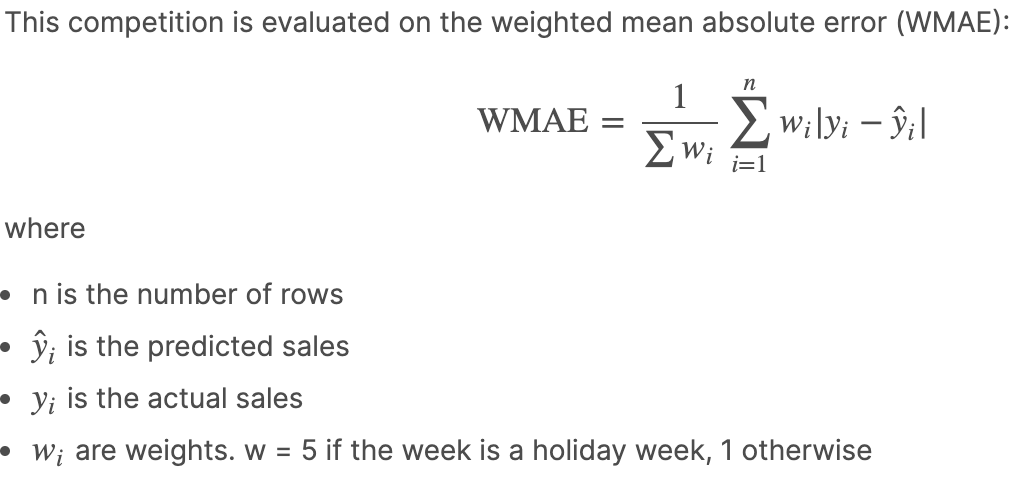
We implement it in the function below

In [ ]:
def WMAE(dataset, real, predicted):
    weights = dataset.isHoliday.apply(lambda x: 5 if x else 1)
    return np.round(np.sum(weights*abs(real-predicted))/(np.sum(weights)), 2)

The model we choose for this case is the Random Forest model. Random forests is an ensemble learning method for classification or regression. It operates by constructing a multitude of decision trees at training time and outputting the class that is the mode of the classes (classification) or mean prediction (regression) of the individual trees. 

We chose this model because of its ensemble configuration and relatively easy interpretation/implementation, makes this model a powerful tool. Although the **ideal** situation would be testing multiple models and see which one performs better, we are limited by computational power on kaggle, so to make it faster, we will try only this model.



We split again the dataset into test and train set and create a function in order to hypertune the model

In [ ]:
from sklearn.tree import DecisionTreeRegressor

X = dataset_model_final.drop('weeklySales',axis=1)
y = dataset_model_final['weeklySales']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)



def model_hypertuning(max_d,max_estimators):
    '''hypertune random forest model'''

    print('Random forest model started')
    error_train = []
    max_depth = np.arange(10, max_d+10, 10).tolist()
    n_estimators = np.arange(10, max_estimators, 20).tolist()
    hyperparams = []
    """Calculating errors for maximum depth and number of estimators parameters."""
    for i in max_depth: 
        print("Max Depth: %f" % i)
        print()
        for j in n_estimators: 
            print("Estimators: %f" % j)
            rf = RandomForestRegressor(max_depth=i, n_estimators=j, n_jobs=-1) 
            rf.fit(X_train, y_train)  
            y_pred_train_rf = rf.predict(X_train) 
            error_train.append(WMAE(X_train,y_train, y_pred_train_rf)) 
            hyperparams.append({'Maximum Depth':i, 'No. of Estimators':j})
            
    return error_train,hyperparams

Now we hypertune the model 

In [ ]:
tuning_model_rf = model_hypertuning(40,140)

Once we have hypertuned the model, we check what is the ideal configuration.

In [ ]:
hyperparams = pd.DataFrame(tuning_model_rf[1])
hyperparams['Train Error']=tuning_model_rf[0]
hyperparams_pivot = pd.pivot_table(hyperparams,'Train Error','Maximum Depth','No. of Estimators')

plt.figure(figsize=(10,6))
p1 = sns.heatmap(hyperparams_pivot,annot=True, annot_kws={"size": 8}, fmt='g') 

hyperparams_pivot.head()

 After tuning our model, we re-run it with the best configurations. We see that 110 estimators and 40 is the ideal.

In [ ]:
model_rf = RandomForestRegressor(max_depth= 40, n_estimators=110,n_jobs=-1).fit(X_train, y_train) # Fit the model with best hyper parameter values.
y_pred = model_rf.predict(X_test) # Predict the test data.
print('Weighted Mean Absolute Error (WMAE) for Random Forest Regression:', WMAE(X_test,y_test, y_pred)) # Get WMAE score.

In [ ]:
# regression plot using seaborn
fig = plt.figure(figsize=(10, 7))
sns.regplot(x=y_test, y=y_pred)

Kaggle says we need to predict with the test data, so we will re-run the model with the test data, but first we need to organize the test dataset. We will apply the same data cleaning as before.

In [ ]:
#Re-read the data 
test = pd.read_csv("../input/walmart-recruiting-store-sales-forecasting/test.csv.zip", names=['Store','Dept','Date','isHoliday'],sep=',', header=0)
train = pd.read_csv("../input/walmart-recruiting-store-sales-forecasting/train.csv.zip", names=['Store','Dept','Date','weeklySales','isHoliday'],sep=',', header=0)
features = pd.read_csv("../input/walmart-recruiting-store-sales-forecasting/features.csv.zip",sep=',', header=0,
                       names=['Store','Date','Temperature','Fuel_Price','MarkDown1','MarkDown2','MarkDown3','MarkDown4',
                              'MarkDown5','CPI','Unemployment','IsHoliday']).drop(columns=['IsHoliday'])
stores = pd.read_csv("../input/walmart-recruiting-store-sales-forecasting/stores.csv", names=['Store','Type','Size'],sep=',', header=0)
test.head()

In [ ]:
# Joining test data with store and features.
test_final = test.merge(features, on=['Store', 'Date'], how='inner').merge(stores, on=['Store'], how='inner')

# Converting Date to datetime
test_final['Date'] = pd.to_datetime(test_final['Date'])

# Extract date features
test_final['year']=test_final['Date'].dt.year
test_final['month']=test_final['Date'].dt.month
test_final['day']=test_final['Date'].dt.day
test_final['week']=test_final['Date'].dt.week

#One hot encoding 
test_final = pd.get_dummies(test_final)

#fill nans with 0
test_final = test_final.fillna(0)

#drop date
test_final = test_final.drop(['Date','day'], axis=1)

#add easter holiday
test_final.loc[(test_final.year==2013) & (test_final.week==13), 'isHoliday'] = True

#convert binary to numeric
test_final = test_final*1

def check_holidays(year,month):
    '''
    For convenience, the four holidays fall within the following weeks in the dataset (not all holidays are in the data):

    Super Bowl: 12-Feb-10, 11-Feb-11, 10-Feb-12, 8-Feb-13 -> ok
    Labor Day: 10-Sep-10, 9-Sep-11, 7-Sep-12, 6-Sep-13 -> ok
    Thanksgiving: 26-Nov-10, 25-Nov-11, 23-Nov-12, 29-Nov-13 -> ok
    Christmas: 31-Dec-10, 30-Dec-11, 28-Dec-12, 27-Dec-13
    '''
    return test_final[(test_final.isHoliday == 1)  & (test_final.year == year) & (test_final.month == month)]

check_holidays(2013,2) 

Now that we have eveything numeric, we will convert select only the important features we selected initially 

In [ ]:
test_final = test_final[['Store','Dept','Temperature','week','isHoliday','Size']]
test_final.head()

Final prediction

In [ ]:
y_pred_final = model_rf.predict(test_final) # Predict the test data.

# **Submission**

In [ ]:
test_file = pd.read_csv("../input/walmart-recruiting-store-sales-forecasting/test.csv.zip")

# Weekly Sales Prediction is the final file to be submitted in Kaggle.
submission = pd.DataFrame({
        "Id": test_file.Store.astype(str)+'_'+test_file.Dept.astype(str)+'_'+test_file.Date.astype(str), 
        "Weekly_Sales": y_pred_final # This is predicetd Weekly Sales on final test data using Random Forest regression.
    })

submission.to_csv('Prediction_final.csv', index=False) # Final submission.